# Integrating data from different mouse MuSCs

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import bbknn
from scipy import sparse
import collections
import scrublet as scr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.io
import jp_single

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='YlOrRd')
sc.logging.print_version_and_date()

Running Scanpy 1.9.2, on 2023-06-20 10:03.


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells

In [3]:
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

***
Import data

In [4]:
raw_adata = sc.read('/public/LiuTL/jupyter_notebook/skeletal_muscle/mouse_muscle/write/Mouse_SKM_sc_summary_v1.0_adata_mouse_sc.h5ad')
adata_total = sc.read('/public/LiuTL/jupyter_notebook/skeletal_muscle/mouse_muscle/write/Mouse_SKM_bbknnv2_v1.0_adata_bbknnv1.h5ad')

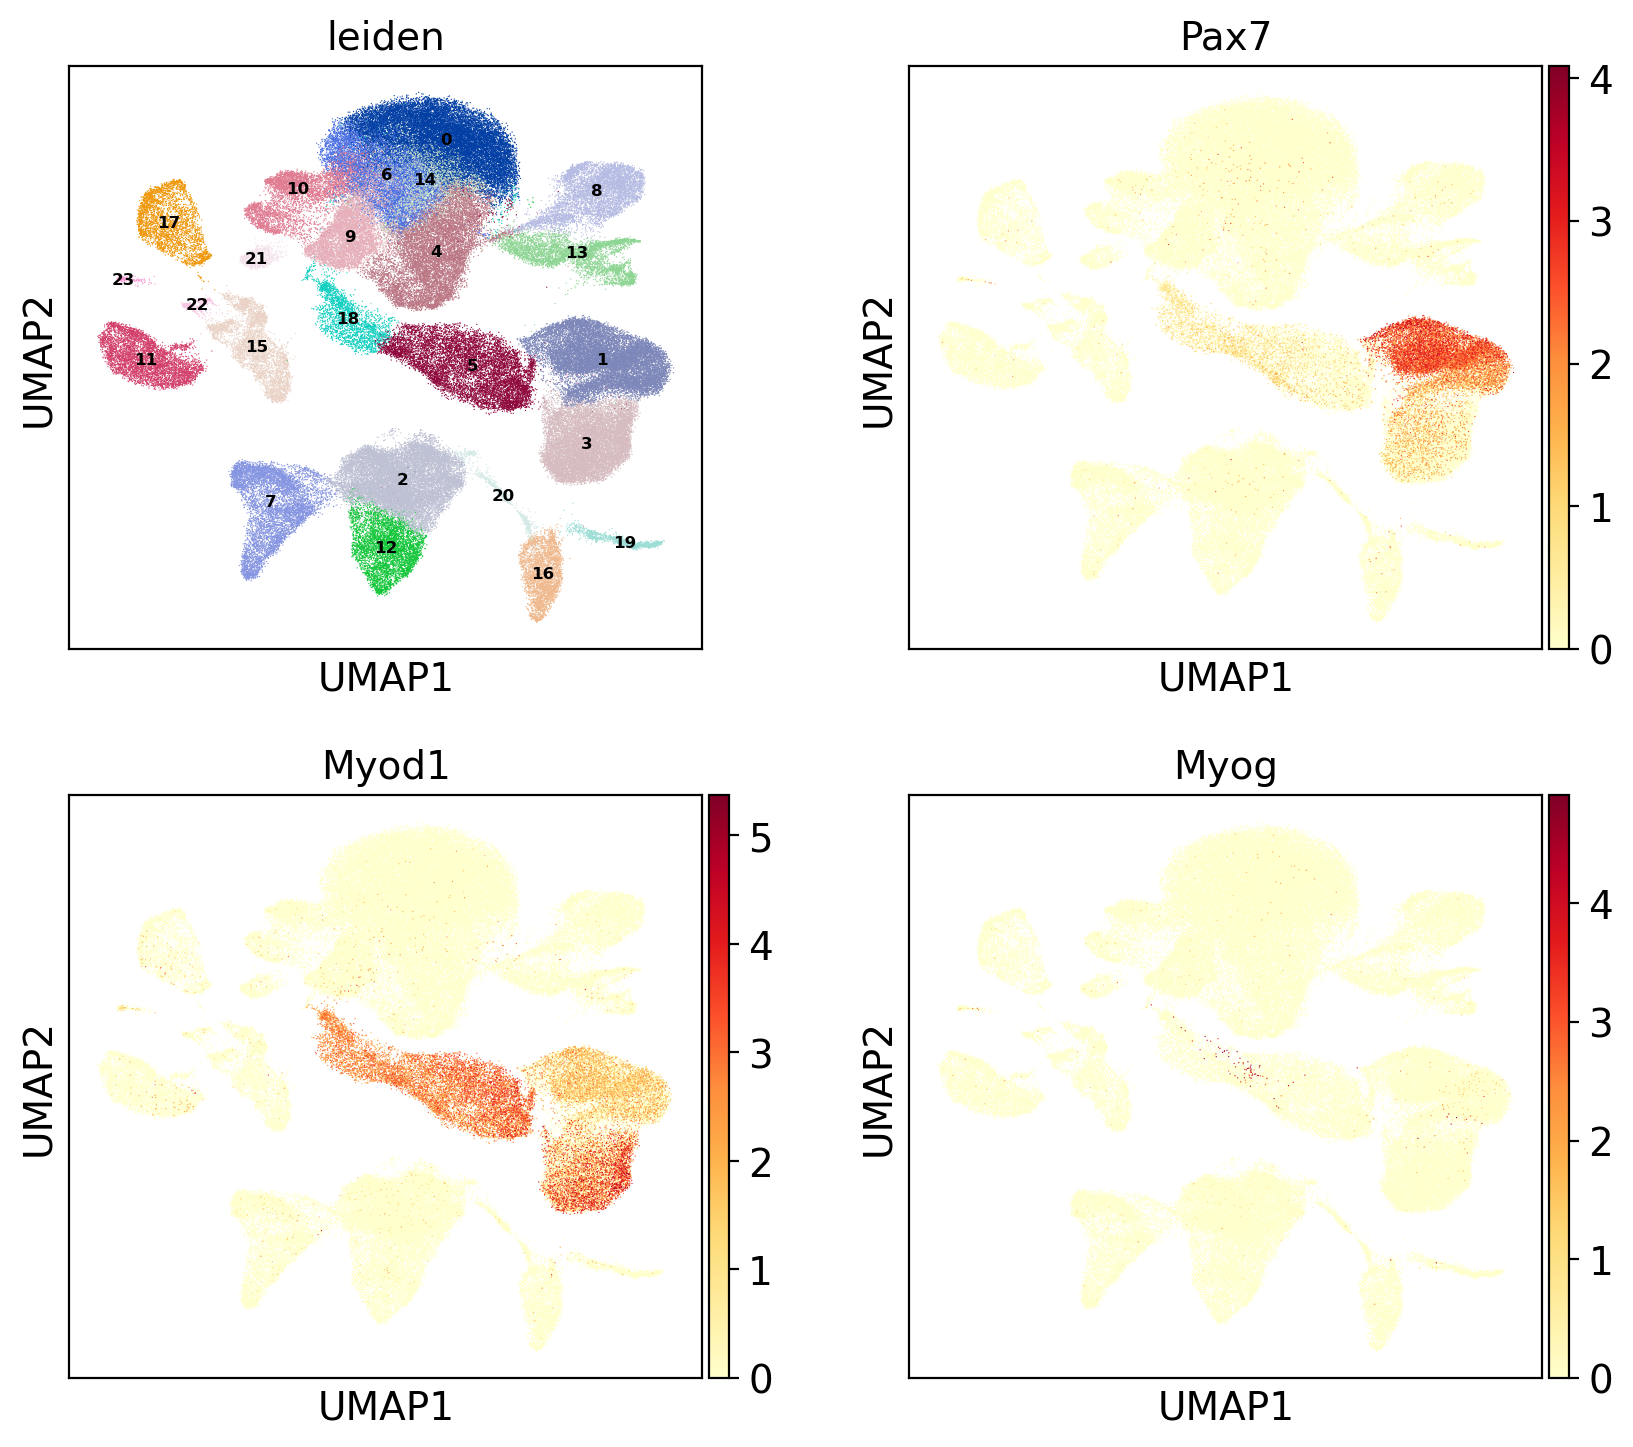

In [5]:
sc.pl.umap(adata_total,color=['leiden','Pax7','Myod1','Myog'],legend_loc='on data',legend_fontsize=6,ncols=2)

In [6]:
raw_adata

AnnData object with n_obs × n_vars = 148939 × 12349
    obs: 'batch', 'Age_bin', 'Age_mo', '10X_chemistry', 'Muscle', 'Source', 'Mito_per', 'Old_annotation', 'Sex', 'Sample_ID'
    var: 'mito', 'gene_ids-0', 'feature_types-0', 'genome-0', 'GeneName-0', 'n_cells-1'
    layers: 'counts'

In [7]:
cell_list1 = adata_total[adata_total.obs['leiden']=='1'].obs.index
cell_list2 = adata_total[adata_total.obs['leiden']=='3'].obs.index
cell_list3 = adata_total[adata_total.obs['leiden']=='5'].obs.index
cell_list4 = adata_total[adata_total.obs['leiden']=='18'].obs.index

cell_list = cell_list1.append(cell_list2).append(cell_list3).append(cell_list4)

In [8]:
adata = raw_adata[cell_list]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 38001 × 12349
    obs: 'batch', 'Age_bin', 'Age_mo', '10X_chemistry', 'Muscle', 'Source', 'Mito_per', 'Old_annotation', 'Sex', 'Sample_ID'
    var: 'mito', 'gene_ids-0', 'feature_types-0', 'genome-0', 'GeneName-0', 'n_cells-1'
    layers: 'counts'

In [14]:
adata.obs['total_annotation'] = adata_total.obs['leiden']

Trying to set attribute `.obs` of view, copying.


In [15]:
adata.layers['counts'] = adata.X.copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 38001 × 12349
    obs: 'batch', 'Age_bin', 'Age_mo', '10X_chemistry', 'Muscle', 'Source', 'Mito_per', 'Old_annotation', 'Sex', 'Sample_ID', 'total_annotation'
    var: 'mito', 'gene_ids-0', 'feature_types-0', 'genome-0', 'GeneName-0', 'n_cells-1'
    layers: 'counts'

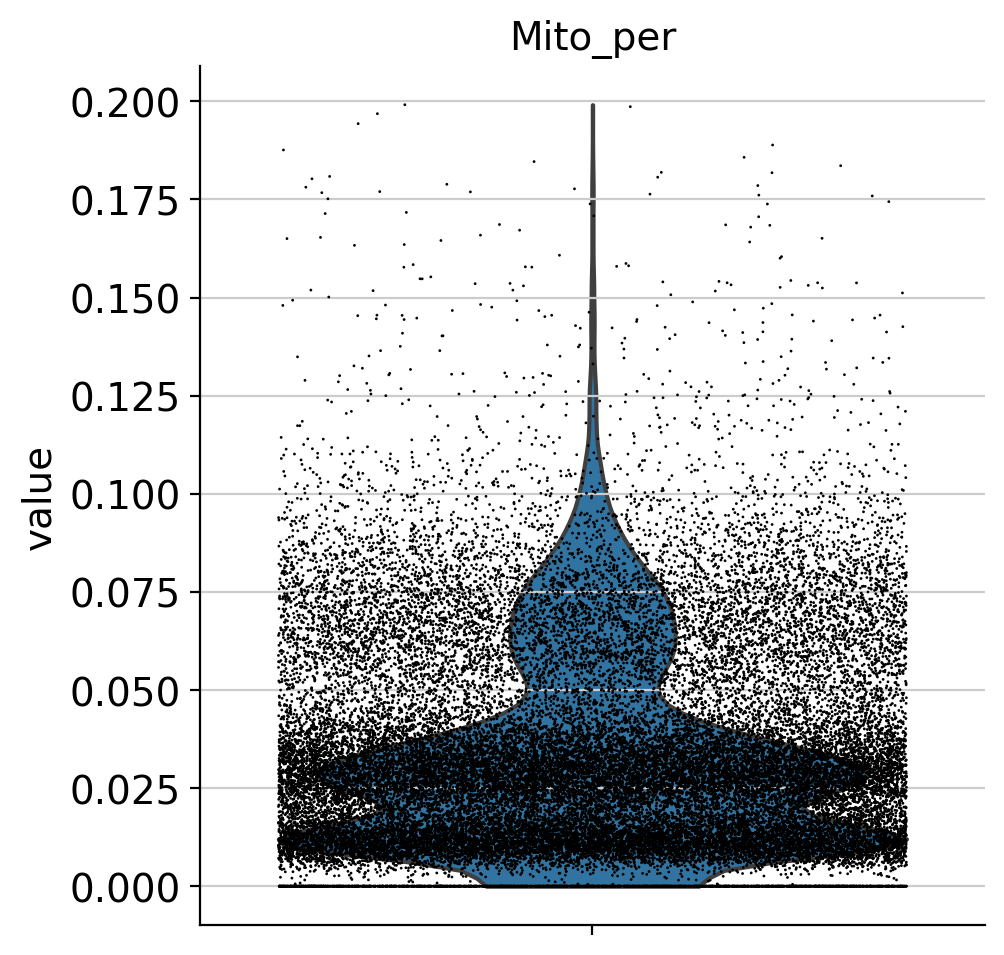

In [17]:
sc.pl.violin(adata,['Mito_per',],jitter=0.4, multi_panel=True)

In [18]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

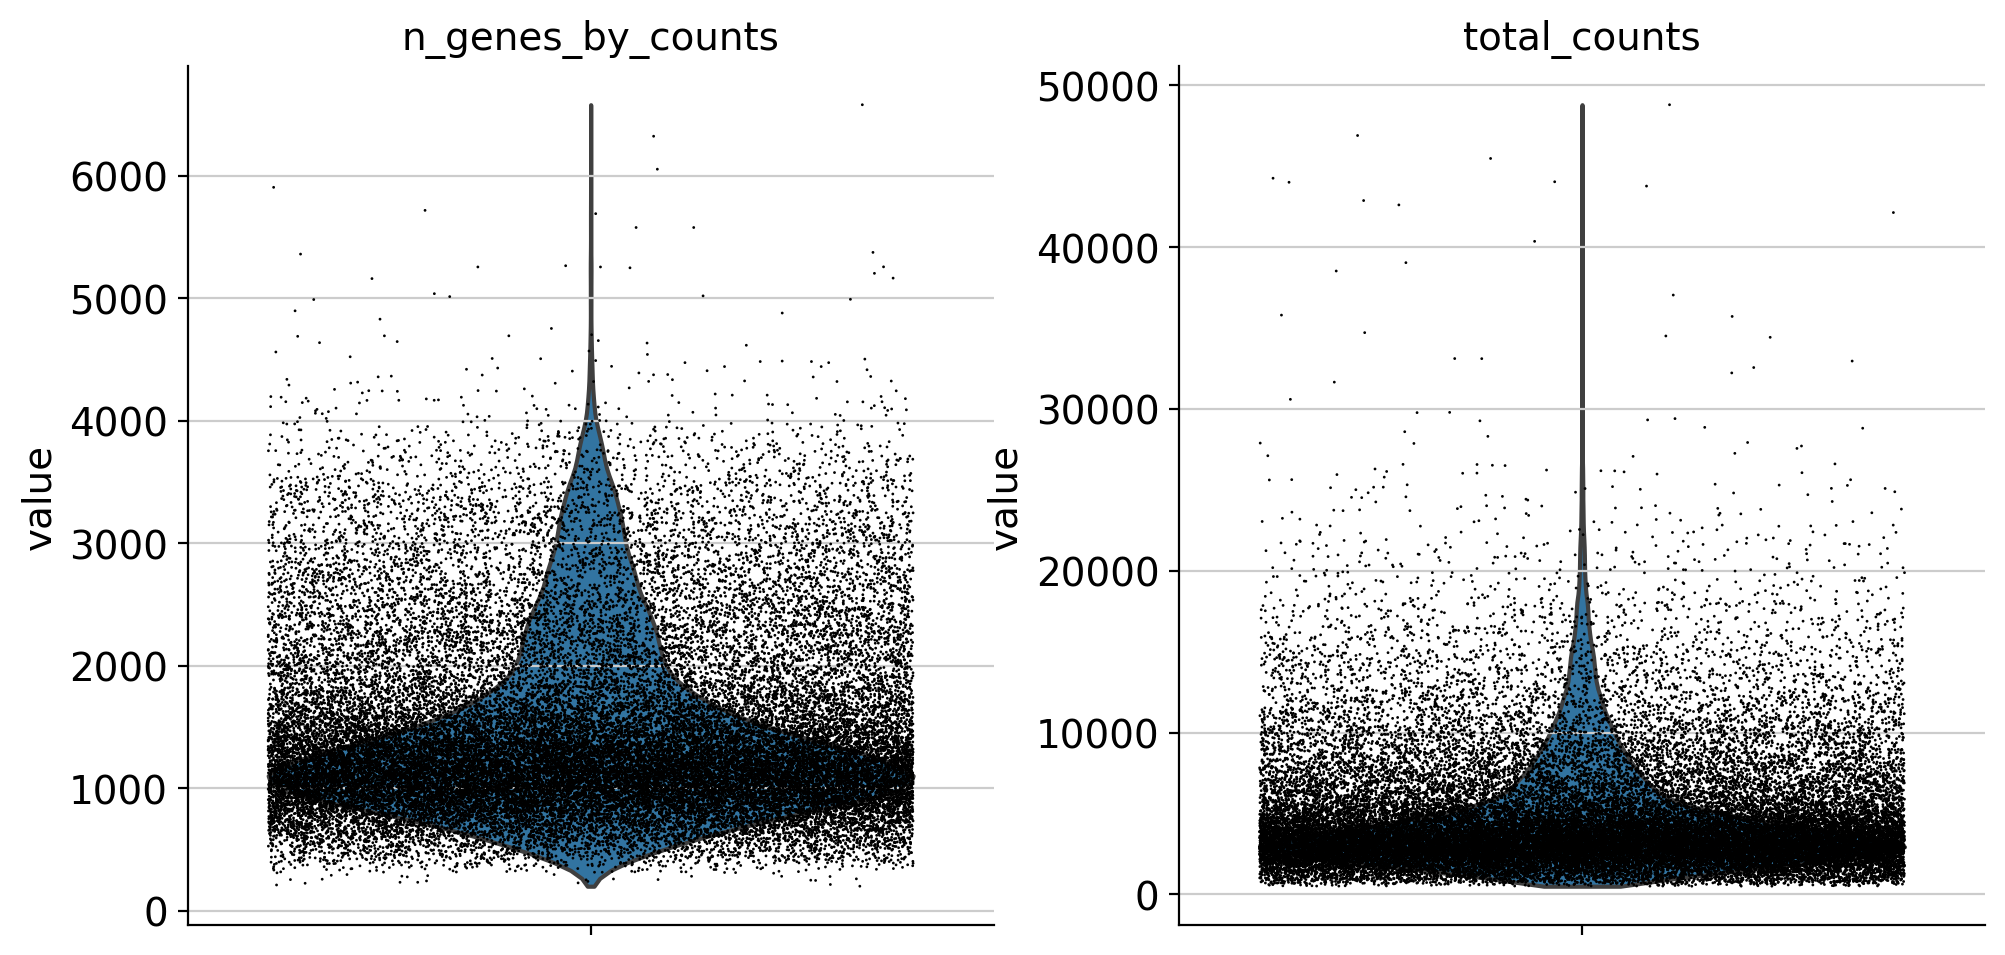

In [19]:
sc.pl.violin(adata,['n_genes_by_counts','total_counts',],jitter=0.4, multi_panel=True)

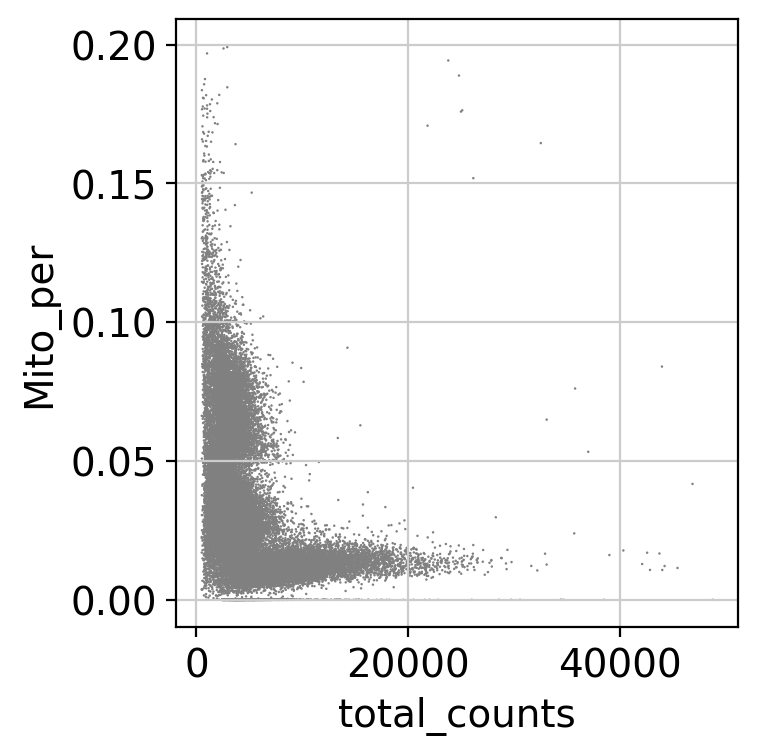

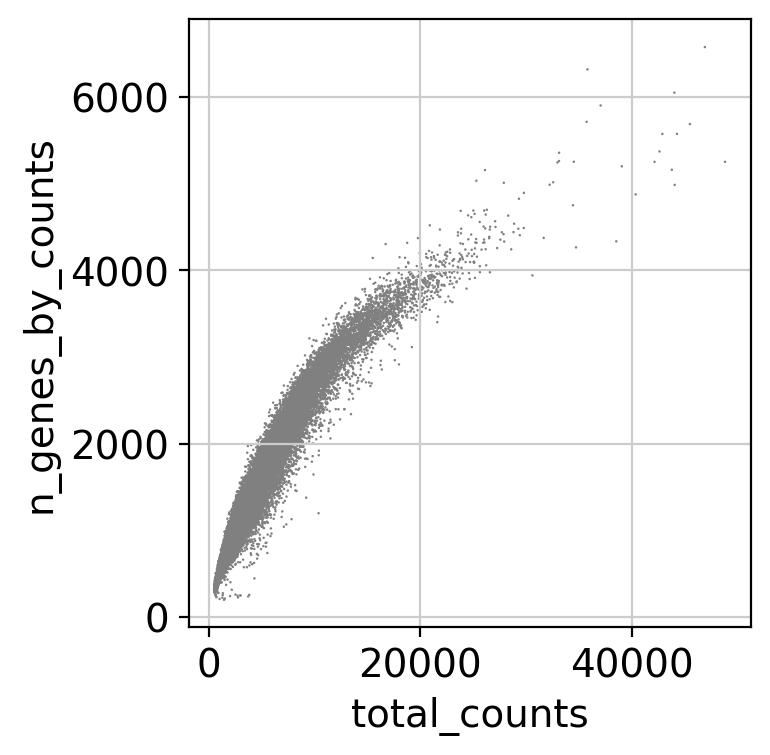

In [20]:
sc.pl.scatter(adata, x='total_counts', y='Mito_per')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [21]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [22]:
radata = adata.copy()

In [23]:
sc.pp.log1p(adata)

***
Highly veriable genes

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


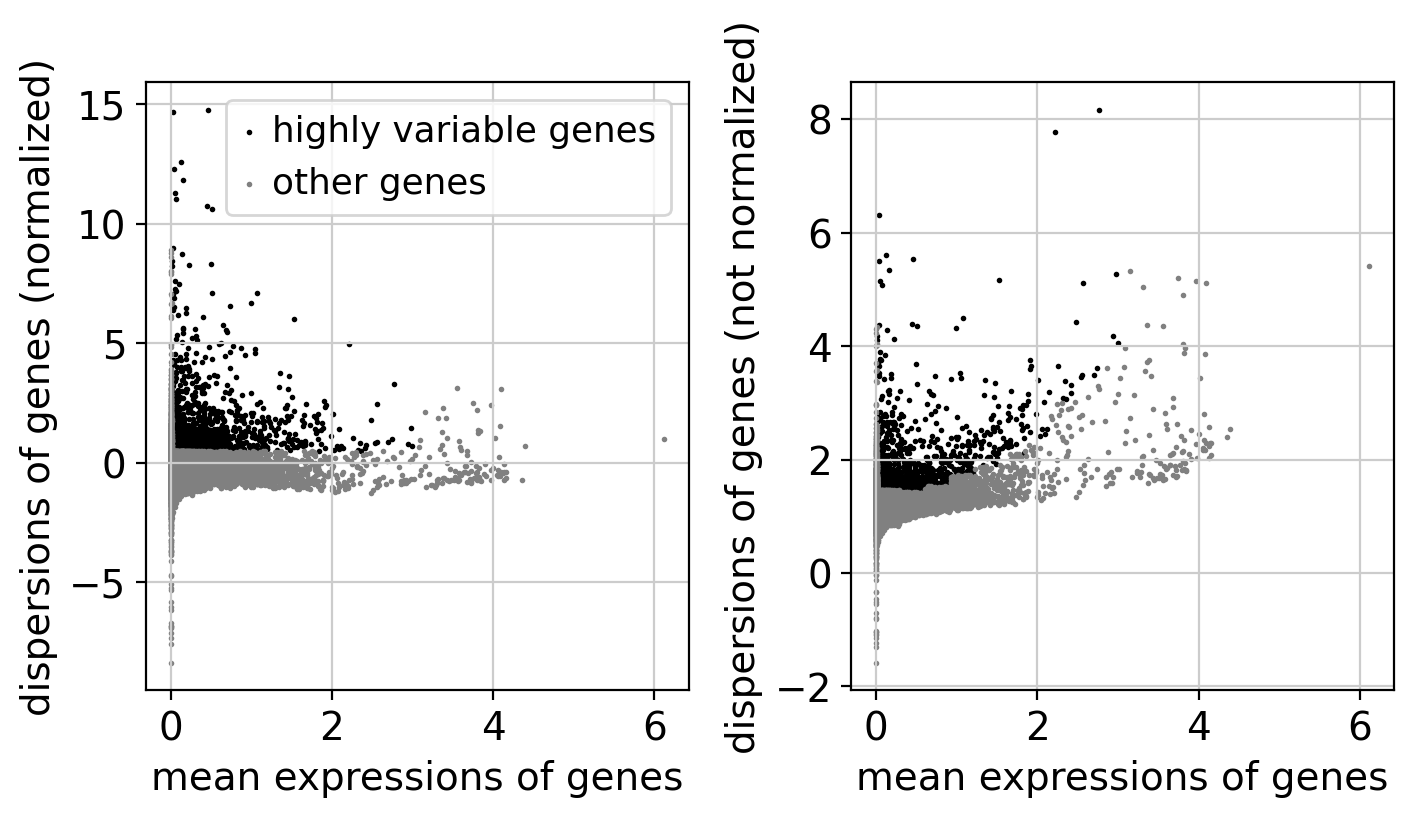

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
adata = adata[:, adata.var['highly_variable']]

In [25]:
sc.pp.scale(adata, max_value=10)

/home/LiuTL/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [26]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [27]:
adata

AnnData object with n_obs × n_vars = 38001 × 1657
    obs: 'batch', 'Age_bin', 'Age_mo', '10X_chemistry', 'Muscle', 'Source', 'Mito_per', 'Old_annotation', 'Sex', 'Sample_ID', 'total_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'mito', 'gene_ids-0', 'feature_types-0', 'genome-0', 'GeneName-0', 'n_cells-1', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

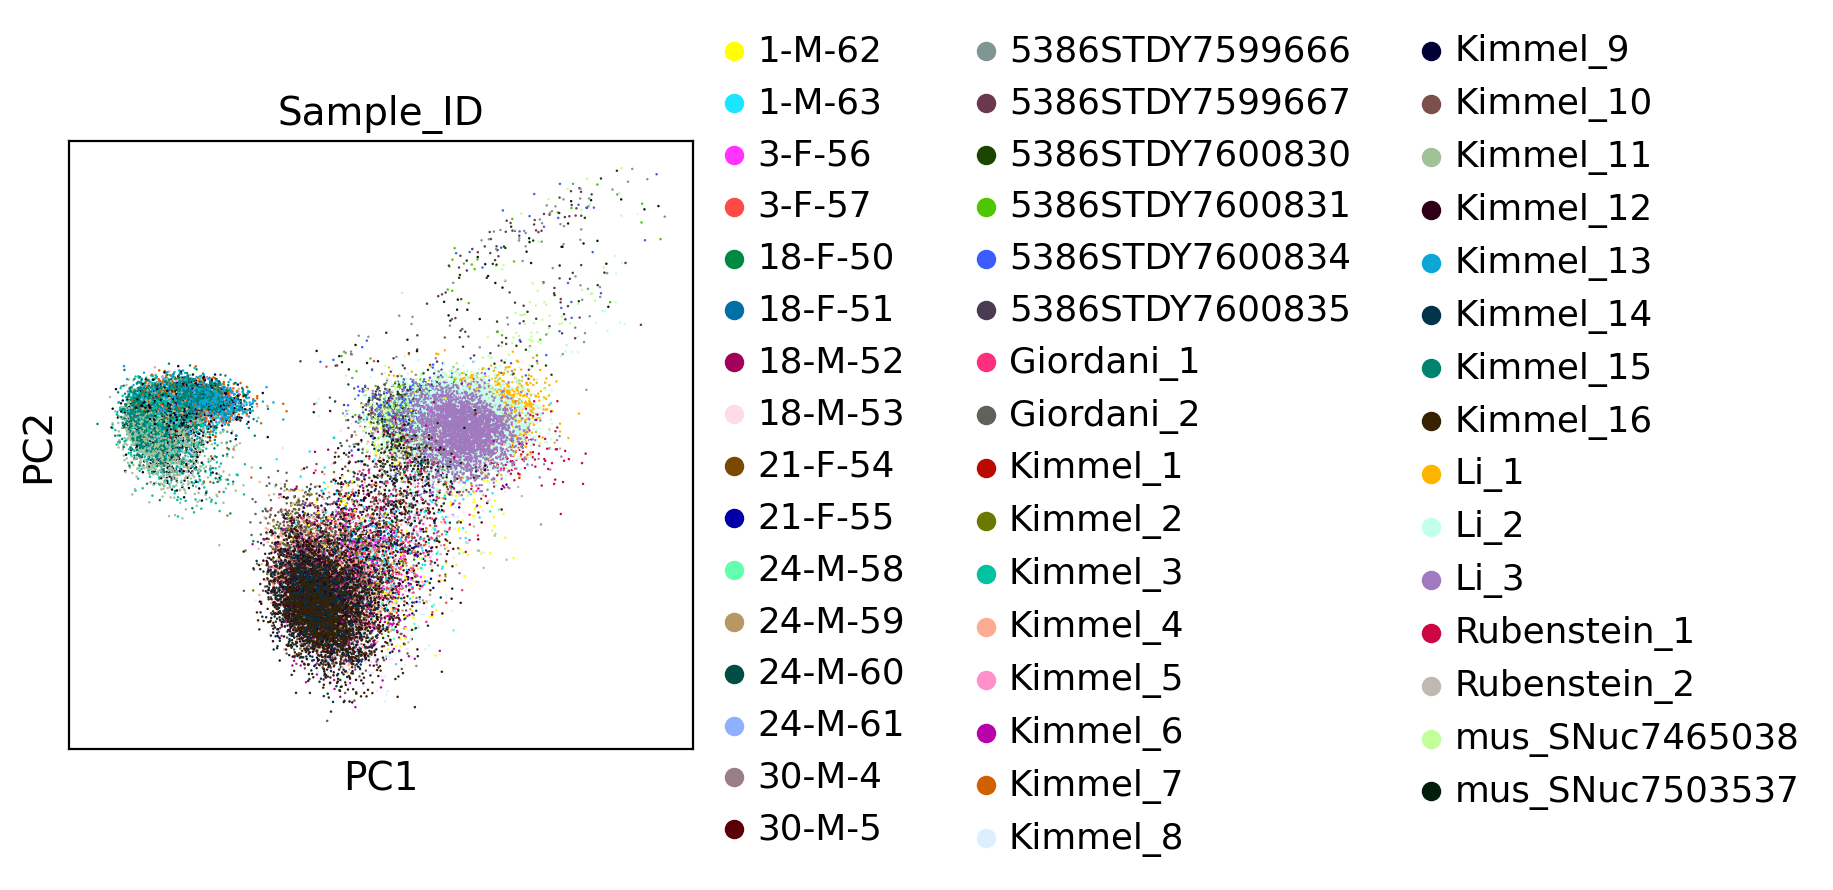

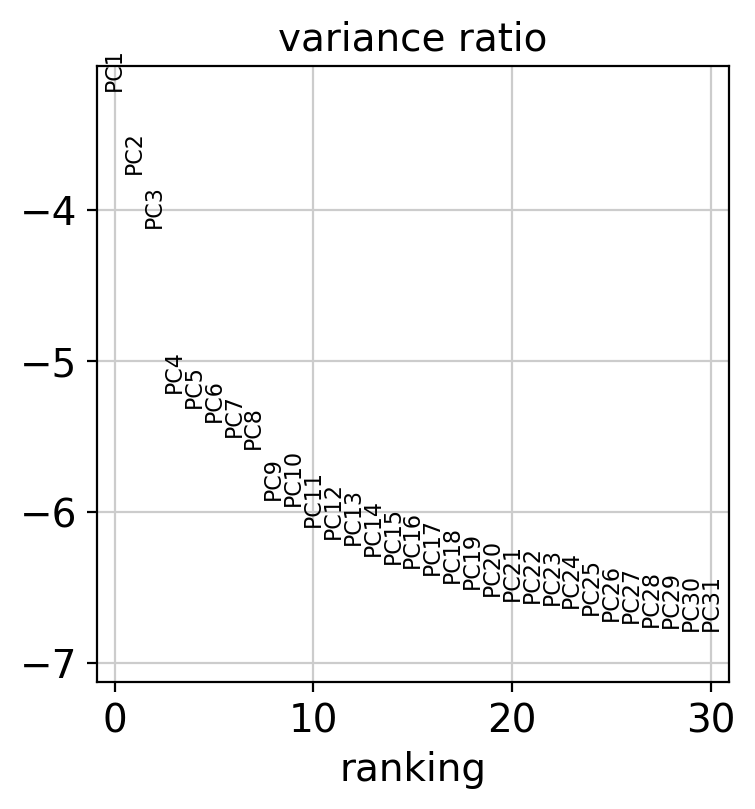

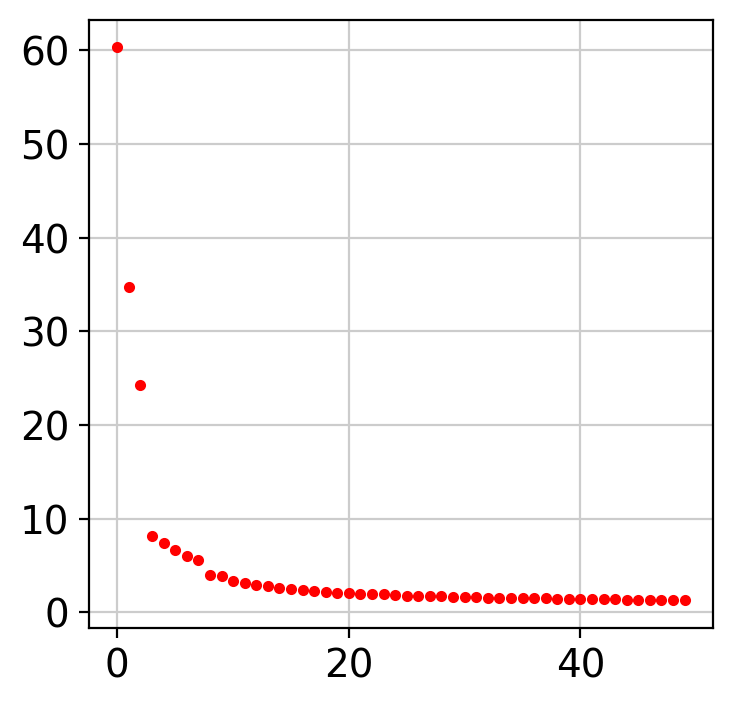

In [28]:
sc.pl.pca(adata,color='Sample_ID')
sc.pl.pca_variance_ratio(adata, log=True)
plt.plot(adata.uns['pca']['variance'],'r.')

In [5]:
number_pcs = 15

***
BBKNN V1

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:46)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)


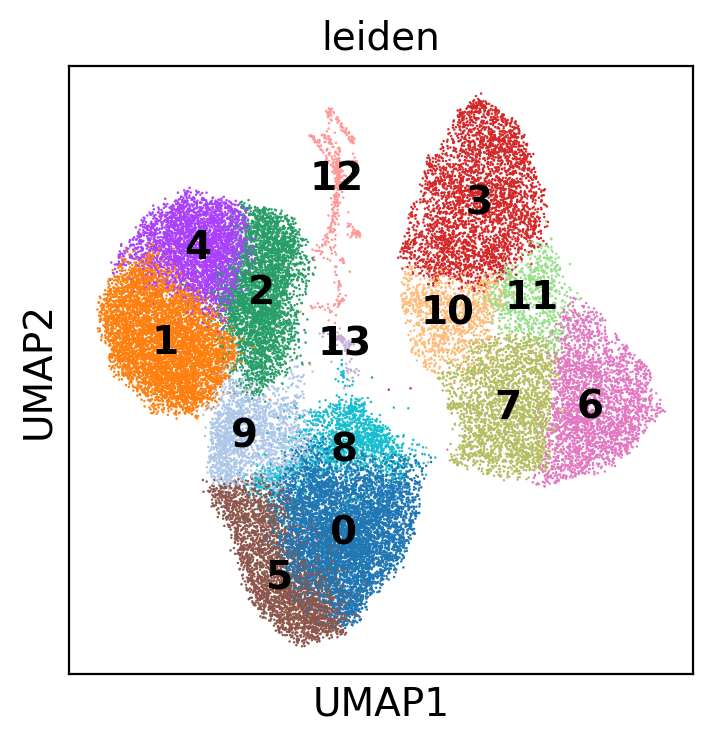

In [6]:
adata_bbknn_scale_v1 = bbknn.bbknn(adata,batch_key='Source',n_pcs=number_pcs,neighbors_within_batch=7,copy=True)
sc.tl.umap(adata_bbknn_scale_v1)
sc.tl.leiden(adata_bbknn_scale_v1,resolution=1)
sc.pl.umap(adata_bbknn_scale_v1, color=['leiden'],legend_loc='on data')

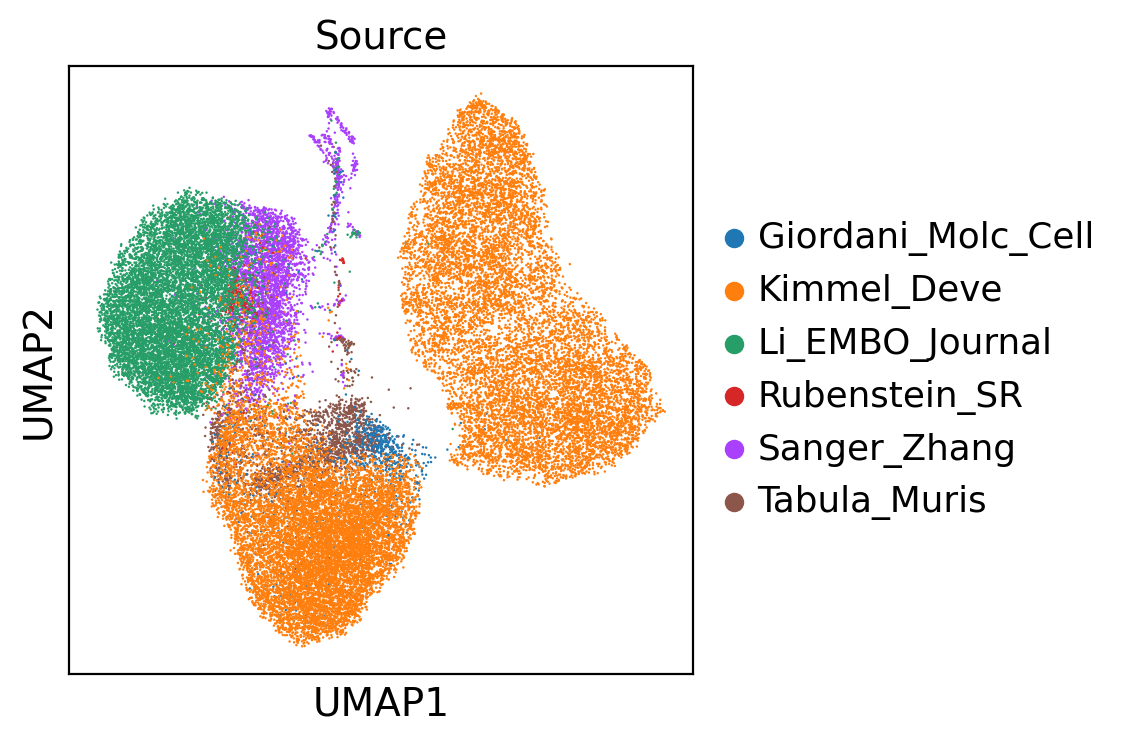

In [5]:
sc.pl.umap(adata_bbknn_scale_v1, color=['Source'],)

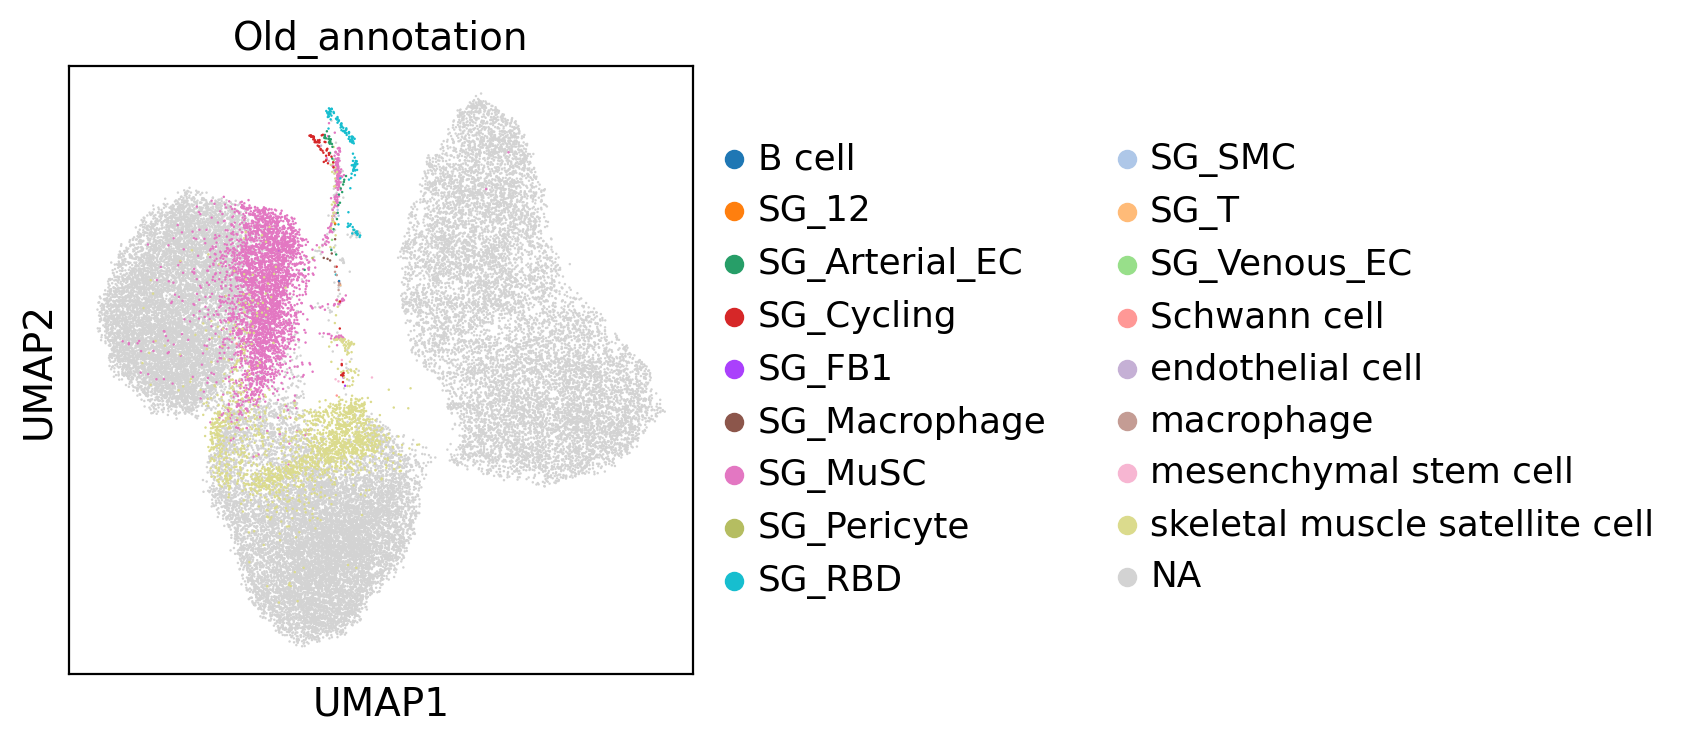

In [9]:
sc.pl.umap(adata_bbknn_scale_v1, color=['Old_annotation'],)

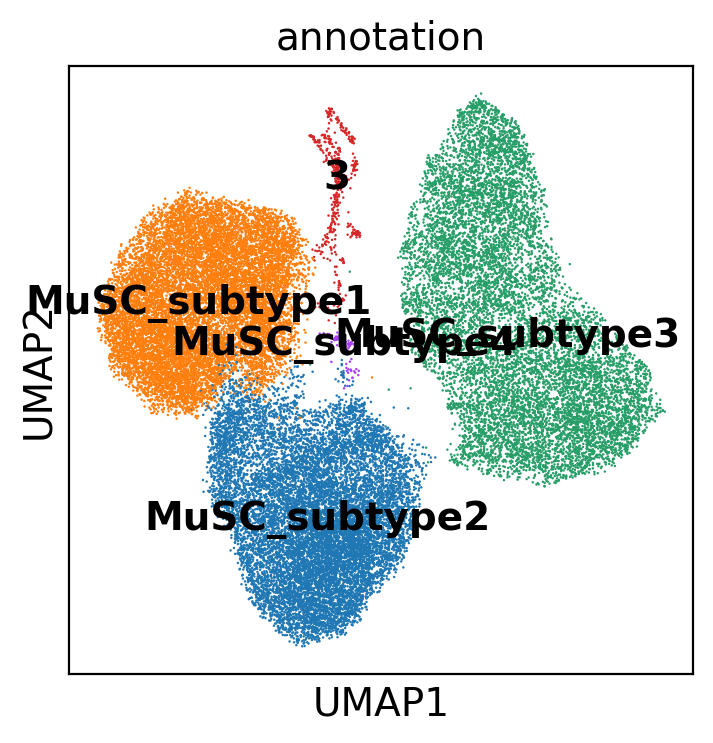

In [26]:
sc.pl.umap(adata_bbknn_scale_v1, color=['annotation'],legend_loc='on data')

In [10]:
adata_mix_index = list(adata_bbknn_scale_v1[adata_bbknn_scale_v1.obs['annotation']!='3'].obs.index)
adata_bbknn_scale_v2 = adata_bbknn_scale_v1[adata_mix_index]

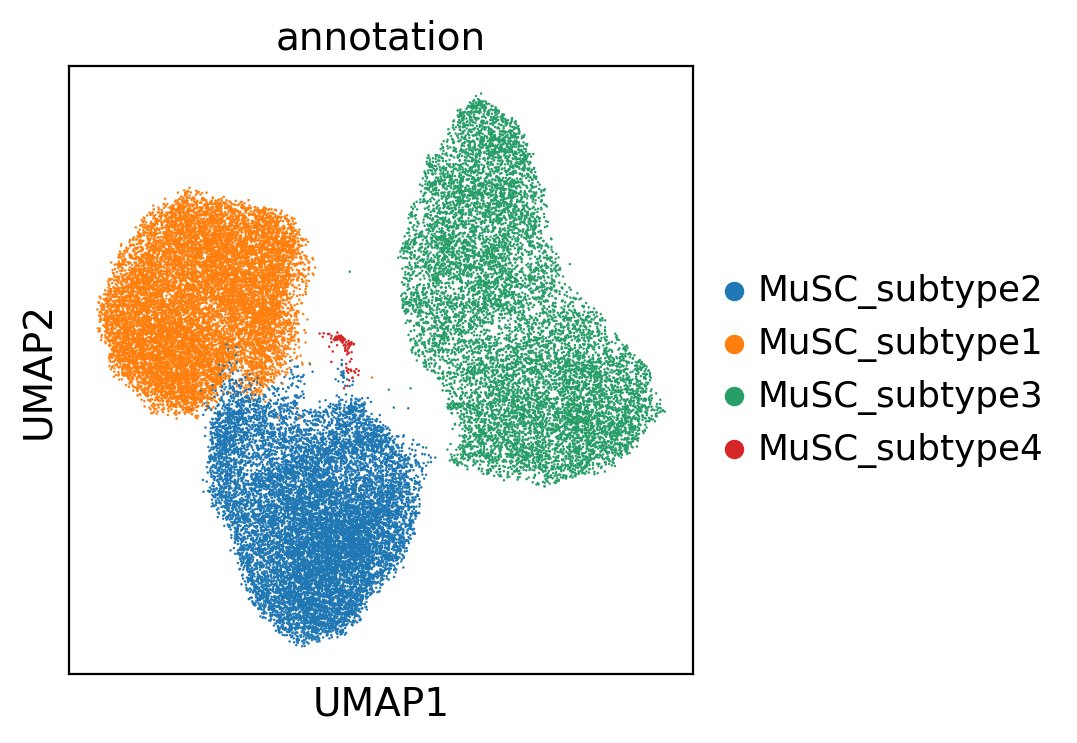

In [50]:
sc.pl.umap(adata_bbknn_scale_v2, color=['annotation'],save='mouse_integrate_MuSC_bbknn_v1.0_adata_bbknn_scale_v2_leiden.pdf')

Trying to set attribute `.uns` of view, copying.


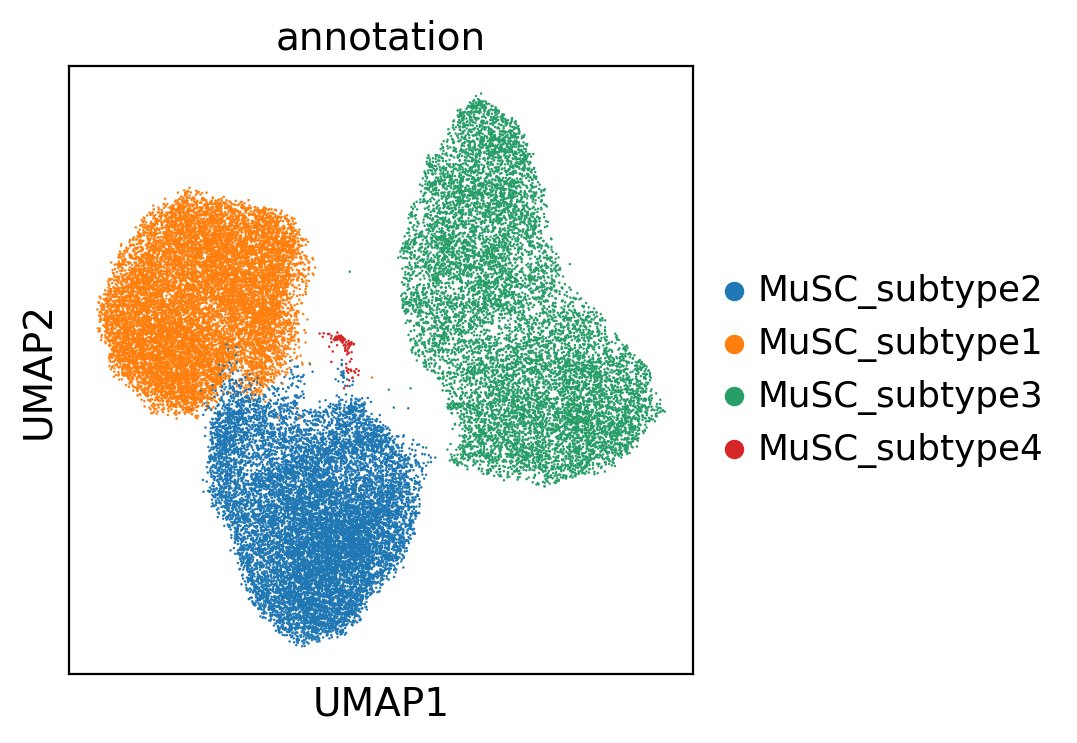

In [11]:
sc.pl.umap(adata_bbknn_scale_v2, color=['annotation'],)

/home/LiuTL/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


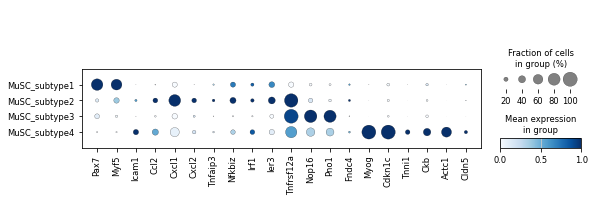

In [10]:
sc.pl.dotplot(adata_bbknn_scale_v2,['Pax7','Myf5','Icam1','Ccl2','Cxcl1','Cxcl2','Tnfaip3','Nfkbiz','Irf1','Ier3','Tnfrsf12a','Nop16','Pno1','Fndc4','Myog','Cdkn1c','Tnni1','Ckb','Actc1','Cldn5'],groupby='annotation',categories_order=['MuSC_subtype1','MuSC_subtype2','MuSC_subtype3','MuSC_subtype4'],
              cmap='Blues',standard_scale='var',)
             #save='mouse_integrate_MuSC_bbknn_v1.0_TNF_marker3.pdf')